In [1]:
import os
from IPython.display import Image
from IPython.display import display

os.chdir("C:\\Users\\aemadzadeh\\Documents\\Projects\\SWFT")
%pwd

u'C:\\Users\\aemadzadeh\\Documents\\Projects\\SWFT'

In [4]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
gps_satellites = [
    [1, 1],
    [1, 0],
    [0, 1],
]
num_sats = len(gps_satellites)
sat_xs, sat_ys = zip(*gps_satellites)

In [5]:
gps_satellites

[[1, 1], [1, 0], [0, 1]]

In [6]:
num_sats

3

In [7]:
sat_xs

(1, 1, 0)

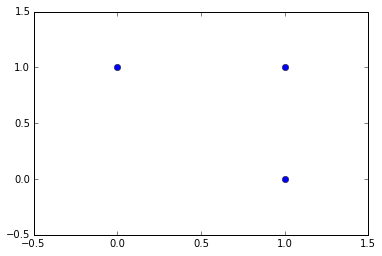

In [8]:
margins(0.5, 0.5)
plot(sat_xs, sat_ys, 'o')

In [9]:
def f(t):
    if t < 0.5:
        x = 1.5*t - 0.2
        y = 0.7*t - 0.1
    else:
        x = -0.7*t + 0.9  # 0.55
        y = 1.5*t - 0.5 # 0.25
    return (x, y)

In [10]:
ts = np.linspace(0, 1, 5000)
xs, ys = np.array(zip(*[f(t) for t in ts]))
print xs[0:4]
print ys[0:4]

[-0.2        -0.19969994 -0.19939988 -0.19909982]
[-0.1        -0.09985997 -0.09971994 -0.09957992]


We have added $v(t)$ to compute the ground truth velocity.

In [11]:
def v(t):
    if t < 0.5:
        vx = 1.5
        vy = 0.7
    else:
        vx = -0.7
        vy = 1.5
    return (vx, vy)

In [12]:
vxs, vys = np.array(zip(*[v(t) for t in ts]))


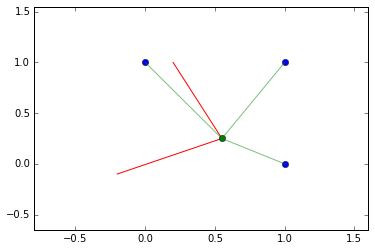

In [13]:
margins(0.5, 0.5)
plot(sat_xs, sat_ys, 'o')
plot(xs, ys, 'r-')

t = 0.5
x, y = f(t)

plot(x, y, 'go')
for i in range(num_sats):
    plot([x, sat_xs[i]], [y, sat_ys[i]], 'g-', alpha=0.5)

In [14]:
def sat_dists(pos):
    x, y = pos[0], pos[1]
    return np.array([sqrt((x - sat_xs[i])**2 + (y - sat_ys[i])**2) for i in range(num_sats)])

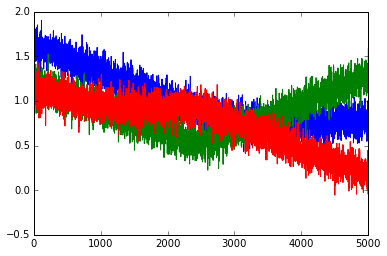

In [15]:
meas = np.array([sat_dists((x, y)) for x, y in zip(xs, ys)])
sigma = 0.1
meas += np.random.normal(0, sigma, meas.shape)
plot(meas);

In [16]:
np.set_printoptions(precision=14)

#Problem Formulation

The state to be estimated at time $t$ is called $X(t)$, and is given by
\begin{equation}
X(t)=
\left(
\begin{array}{cccc}
  x(t) & y(t) & v_x(t) & v_y(t)
\end{array}
\right)^T
\end{equation}
where $x$ and $y$ represent position, and $v_x$ and $v_y$ are velocities.

We use a constant velocity motion model as follows.
\begin{equation}
    \dot{X}(t) = A \, X(t) + w(t)
\end{equation}
where
\begin{equation}
A=
\begin{pmatrix}
    0 & 0 & 1 & 0\\
    0 & 0 & 0 & 1\\
    0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0
\end{pmatrix}
\end{equation}
and $w(t)$ is the process noise which represents the model uncertainty. This noise, models vehicle's position and velocity uncertainties. It is an independent zero mean white noise process with a
known power spectral density, denoted by $W$
\begin{equation}
E[w(t)w(\tau)^T]=W\delta(t-\tau)
\end{equation}
where
\begin{equation}
W=
\begin{pmatrix}
    W_x & 0   & 0   & 0\\
    0   & W_y & 0   & 0\\
    0   & 0   & W_{v_x}   & 0\\
    0   & 0   & 0   & W_{v_y}
\end{pmatrix}
\end{equation}


To obtain the discrete dynamics, the continuous system is sampled with the sampling time $T_s$, The discrete model is as follows.
\begin{equation}
    X(k+1)=F X(k)+ w_d(k)
\end{equation}
where
\begin{equation}
F=
\begin{pmatrix}
    1 & 0 & T_s & 0\\
    0 & 1 & 0   & T_s\\
    0 & 0 & 1   & 0\\
    0 & 0 & 0 & 1
\end{pmatrix}
\end{equation}

Since $w(t)$ is zero mean, $w_d(k)$ is zero mean as well, and
\begin{equation}
  E[w_d(k)w_d(j)^T]=Q\delta_{kj}
\end{equation}
where $Q$, which is the variance of the process noise, is
\begin{equation}
Q=T_sW
\end{equation}

Assume satellite cooridantes are $(x_1,y_1)$, $(x_2,y_2)$, and $(x_3,y_3)$. Since the measurements are the distance between the vehicle and the satellites, the measurement equation is given by
\begin{equation}
  Z(k)=h(X(k))+\eta_d(k)
\end{equation}
where
\begin{equation}
h(X(k))=
\begin{pmatrix}
    \sqrt{(x(k)-x_1)^2 + (y(k) - y_1^2)}\\
    \sqrt{(x(k)-x_2)^2 + (y(k) - y_2^2)}\\
    \sqrt{(x(k)-x_3)^2 + (y(k) - y_3^2)}\\
\end{pmatrix}
\end{equation}
and $\eta_d(k)$ is the measurement noise. It is modeled by an independent zero-mean white noise sequence
\begin{equation}
    E[\eta_d(k) \, {\eta_d(j)}^T]= R\delta_{kj}
\end{equation}
where
\begin{equation}
R=
\begin{pmatrix}
    \sigma_1^2 & 0 & 0 \\
    0          & \sigma_2^2 & 0 \\
    0 & 0 & \sigma_3^2
\end{pmatrix}
\end{equation}

In brief, the problem that we are trying to solve is to estimate $X(k)$ using obtained measurement $Z(k)$. In other words, our assumption is that we have access to the noisy, but unbiased, measurements of the vehicle position. Then, we try to filter out the noise, and find the true trajectory of the vehicle.

#Extended Kalman Filter

In the following, we offer a solution using the extended Kalman filter. Note that although the process model is linear, the measurement equation is nonlinear, and as a result, the linear Kalman filter will not work.

Let $\hat{X}_k^{(-)}$ be the *a priori* system state estimate at time $k$,
and $P_k^{(-)}$ be the *a priori* estimation error covariance, which are
based on all measurements up to $Z_{k-1}$ . Similarly, let $\hat{X}_k^{(+)}$ and $P_k^{(+)}$
denote the *a posteriori* estimate and covariance matrix
after the measurement has been processed. Assuming that
measurements start at $k=1$, the extended Kalman filter equations in discrete
time are as follows.

The filter's initial values are set as
\begin{align}
    \hat{X}_0^{(+)}&=E[X_{0}]\\ P^{(+)}_0&=E[(X_{0}-\hat{X}_{0}^{(+)})
    (X_{0}-\hat{X}_{0}^{(+)})^T]
\end{align}
the time propagation equations are 
\begin{align}
    \hat{X}^{(-)}_{k}&=F \hat{X}_{k-1}^{(+)} \\
    P^{(-)}_{k}&=F P^{(+)}_{k-1} \Phi^T + Q
\end{align}
the measurement update equations are
\begin{align}
    \tilde{y}_k &= Z_k - h(\hat(X)_k^{(-)})\\
    S_k &= H_kP_k^{(-)}H_k^T+R\\
    K_k&=P_k^{(-)}H_k^TS_k^{-1}\\
    \hat{X}_{k}^{(+)}&=
    \hat{X}_{k}^{(-)}+K_k\tilde{y}_k \\
    P_k^{(+)}&=[I-K_k H_k]P_k^{(-)}[I-K_kH_k]^T+K_kRK_k^T \\
 \end{align}
where $\tilde{y}_k$ is *innovation*, $S_k$ is *innovation covariance*, and
\begin{equation}
    H_k = \frac{\partial h}{\partial X}  \bigg\vert_{\hat{X}_k^{(-)}}.
\end{equation}

For our formulated problem, the $i$-th row of the linearized measurement matrix $H_k$ is given by the following.
\begin{equation}
    H_k^{(i)} = \frac{1}{\sqrt{(x_k^{(-)} - x_i)^2 + (y_k^{(-)} - y_i)^2}} 
    \begin{pmatrix}
    x_k^{(-)} - x_i & y_k^{(-)} - y_i & 0 & 0
    \end{pmatrix}
\end{equation}


Note that for our implementation of $P_k^{(+)}$ equation, we have used an update equation which has an inherent quadratic form. This, guaranties that the covariance matrix is always positive definite, which makes it robust to numerical round-off errors. 

Also, $R$ and $Q$ in Kalman filter are assumed to be known and constant. In our problem, we just have access to the observed measurements and we have no prior information about $R$ and $Q$. As a result, to implement this filter, we have to guess these filter statistics. Using $R$ and $Q$, we can tell the filter how much confidence we have on the process and measurement models. By increasing $Q$, we show that our process model is less accurate. By incearing $R$, we show that our measurements are more noisy. Using Q, we can take into account posibble changes in vehicle's velocity although the process model assumes a constant velocity model.

We can see from the above equations that Kalman gain $K_k$ is essentialy the ratio between statistical measures of uncertainty in the state estimate and the uncertainty in measurements. Thus, it is *proportional* to the estimate uncertainty and *inversely proportional* to measurement uncertainy. When the measurement ucnertainy is high and the state estimate uncertainty is low, the innovation largely contains noise information. As a result, the filter wants to reduce the weight of those noisy measurements, and change the state estimates a little (Kalman gain is samll). Conversely, when the measurement uncertainty is low and the state estimate uncertainty is high, the innovation contains considerable information about errors in the estimates. Therefore, the filter wants to use those measurements to perform strong corrections to the estimates (large Kalman gain). Also, small measurement errors cause the error covariance to reduce when a new measurement is utilized. Finaly, large measurement uncertainty causes the error covariance diminish less rapidly or to incease, dependeing on the system condition. 

We can also see that *a priori* estimate covariance $P_k^{(-)}$ is direclty proportinal to $Q$, and $P_k^{()+}$ is proportional to $P_k^{(-)}$. As a result, by increasing $Q$, the covariance of estimate errors goes up. The higher the $Q$ is, the more rapidly the error covariance increases.

#Simulation

The sampling frequency is $Fs = 5000$ Hz.

In [17]:
Fs = 5000
Ts = 1.0/Fs

The state transiton matrix $F$ is:

In [18]:
F = np.array([ [1, 0, Ts, 0],[0, 1, 0, Ts],[0, 0, 1, 0], [0, 0, 0, 1] ])

We try different $Q$ matrices. The first 2 values are covariance of position uncertainties and the second 2 values are covariance of velocity uncertainties.

In [19]:
Q1 = diag([1e-3,1e-3,1e-3,1e-3])
Q2 = diag([1e-3,1e-3,1e-2,1e-2])
Q3 = diag([1e-3,1e-3,1e-1,1e-1])

Q4 = diag([1e-2,1e-2,1e-3,1e-3])
Q5 = diag([1e-1,1e-1,1e-3,1e-3])



We will also try different $R$ matrices and study their effect on the filter's performance.

In [20]:
R1 = 0.1*diag([1,1,1])
R2 = 1*diag([1,1,1])
R3 = 10*diag([1,1,1])
R4 = 100*diag([1,1,1])

Here are the snippets for implementing the extended Kalman filter.

In [21]:
def time_propagation(xhat,P):
    xhat = F.dot(xhat)
    P = ( F.dot(P) ).dot(F.T) + Q
    return (xhat,P)


def linearize_meas(xhat):
    hcol1 = array( [(xhat[0] - sat_xs[i])/sqrt( (xhat[0] - sat_xs[i])**2 + (xhat[1] - sat_ys[i])**2 ) for i in range(num_sats) ] )
    hcol2 = array( [(xhat[1] - sat_ys[i])/sqrt( (xhat[0] - sat_xs[i])**2 + (xhat[1] - sat_ys[i])**2 ) for i in range(num_sats) ] )
    return(np.column_stack([hcol1,hcol2,zeros([3,2])]) )
    
def compute_KF_gain(P,H,R):
    return ( P.dot(H.T) ).dot( np.linalg.inv( H.dot(P).dot(H.T) + R )  )

   

def meas_update(z,xhat,P):
    inov = z - sat_dists(xhat)
    xhat += np.dot(K, inov)
    P = ( ( np.eye(4) - np.dot(K,H) ).dot(P) ).dot( ( np.eye(4) - np.dot(K,H) ).T ) + ( np.dot(K,R) ).dot(K.T)
    return(xhat,P,inov)
    

The covariance matrix $P_0^{(+)}$ is intialized with large values to show that our confidence on initial position and velocity of the vehicle is low, or in other words, the inital estimate uncertainy is high. Our inital guess on the vehicle position and velocity in $x$ and $y$ directions is $(0,0,0,0)$. 

In [49]:

P = 100*np.diag([1,1,1,1])
xhat = np.array([0,0,0,0]).reshape(4,1)

xhat_all = np.array([]).reshape(4,0)
P_all = np.array([]).reshape(4,0)
inov_all = np.array([]).reshape(3,0)
K_norms = np.array([]).reshape(0,1)

Q = Q3
R = R4

for k in  range(len(ts)):
    
    #print "time index %s: \n"%k 
    
    xhat, P = time_propagation(xhat,P)
    #print xhat
    #print diag(P)
    
    H = linearize_meas(xhat)
    #print H
    
    K = compute_KF_gain(P,H,R)
    #print K
    
    z = meas[k,:].reshape(3,1)
    #print z
    
    xhat, P, inov = meas_update(z,xhat,P)
    #print xhat
    #print diag(P)
    
    xhat_all = column_stack([xhat_all, xhat])
    inov_all = column_stack([inov_all, inov])
    P_all = column_stack([P_all, np.diag(P).reshape(4,1)])
    K_norms = row_stack([K_norms,norm(K)])
    
print "Done!"





Done!


For different choices of $R$ and $Q$, we will plot the state estimates versus ground truth, and monitor the standard deviation of estimation errors, and the norm of Kalman gain. We will study the KF performance for these scenarios in the next section.

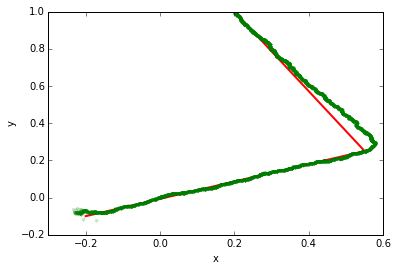

In [50]:
plot(xs,ys, 'r-',linewidth = 2)
plot(xhat_all[0,:],xhat_all[1,:],"g.",alpha = 0.2)
xlabel("x")
ylabel("y")
savefig('R4Q3_xy.png', bbox_inches='tight')


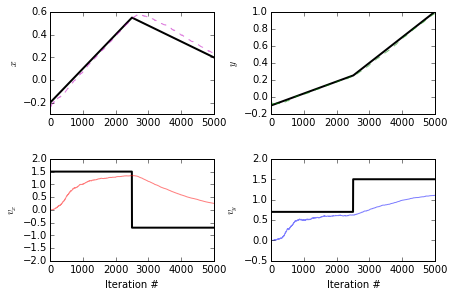

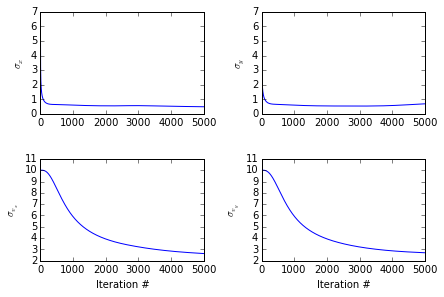

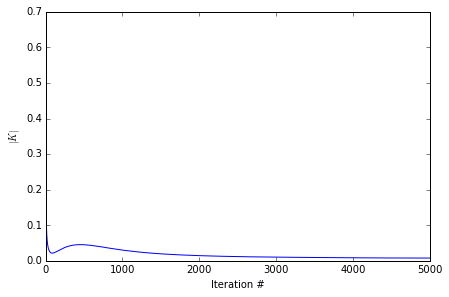

In [23]:

fig, axes = plt.subplots(nrows=3, ncols=3)
fig.tight_layout()

subplot(221)
plot(xs,'-k', linewidth = 2)
plot(xhat_all[0,:],'m--', alpha = .5)
ylabel("$x$")

subplot(222)
plot(ys,'-k', linewidth = 2)
plot(xhat_all[1,:],'g--', alpha = .5)
ylabel("$y$")

subplot(223)
plot(vxs,'-k', linewidth = 2)
plot(xhat_all[2,:],'r-', alpha = .5)
xlabel('Iteration #')
ylabel("$v_x$")
ylim(-2,2)

subplot(224)
plot(vys,'-k', linewidth = 2)
plot(xhat_all[3,:],'b-', alpha = .5)
xlabel('Iteration #')
ylabel("$v_y$")
ylim(-.5,2)

savefig('R4Q1_Xhat.png', bbox_inches='tight')


fig, axes = plt.subplots(nrows=3, ncols=3)
fig.tight_layout()

subplot(221)
plot(sqrt(P_all[0,:]))
ylabel("$\sigma_{x}$")
#ylim(0,3)

subplot(222)
plot(sqrt(P_all[1,:]))
ylabel("$\sigma_{y}$")
#ylim(0,3)

subplot(223)
plot(sqrt(P_all[2,:]))
xlabel('Iteration #')
ylabel("$\sigma_{v_x}$")


subplot(224)
plot(sqrt(P_all[3,:]))
xlabel('Iteration #')
ylabel("$\sigma_{v_y}$")

savefig('R4Q1_sigma.png', bbox_inches='tight')


fig, axes = plt.subplots(nrows=1, ncols=1)
fig.tight_layout()
plot(K_norms)
xlabel('Iteration #')
ylabel("$|K|$")

savefig('R4Q1_K.png', bbox_inches='tight')



We will also monitor the innovation by analyzing its autocorrelation function and power spectrum. If the filter's performance is healthy, the innovation should be close to a white noise. In other words, its autocorrelation function should be close to a Dirac delta function, and its spectrum should be almost flat. Otherwise, that means something is wrong with the filter. For example the assumed model is not accurate, or the noise statistics are incorrect. Since we already know about the change of dynamics at $t=0.5$, we will split the innovation signal in 2 parts for our analysis. The first part is for $t<0.5$ and the second part is for $t \ge 0.5$. We will also monitor the innovation signal in one whole piece.

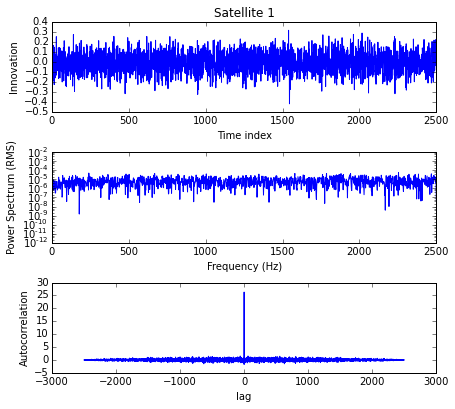

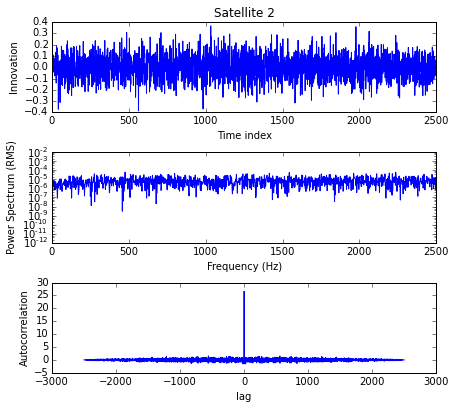

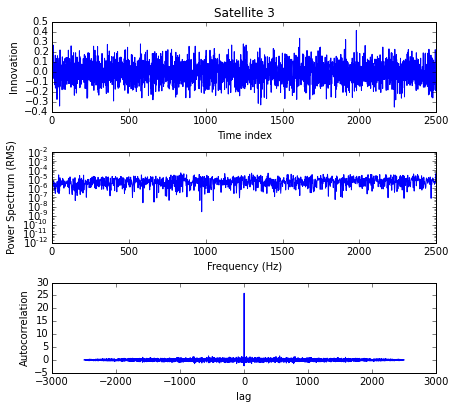

In [302]:
from scipy import signal
import matplotlib.pyplot as plt


inv1 = inov_all[0,ts<.5]
inv2 = inov_all[1,ts<.5]
inv3 = inov_all[2,ts<.5]

f, Pz1 = signal.periodogram(inv1, Fs, scaling = "spectrum")
f, Pz2 = signal.periodogram(inv2, Fs, scaling = "spectrum")
f, Pz3 = signal.periodogram(inv3, Fs, scaling = "spectrum")

Rr1 = correlate(inv1,inv1,mode = "full")
Rr2 = correlate(inv2,inv2,mode = "full")
Rr3 = correlate(inv3,inv3,mode = "full")

lag = range(-len(inv1)+1,len(inv1))

#plt.rc('text', usetex=False)

    
rcParams['text.usetex'] = False

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[0,ts<.5])
xlabel('Time index')
ylabel("Innovation")
title("Satellite 1")

subplot(312)
semilogy(f, Pz1)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr1)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q5_Innov_1_1st_half.png', bbox_inches='tight')



fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[1,ts<.5])
xlabel('Time index')
ylabel("Innovation")
title("Satellite 2")

subplot(312)
semilogy(f, Pz2)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr2)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q5_Innov_2_1st_half.png', bbox_inches='tight')

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[2,ts<.5])
xlabel('Time index')
ylabel("Innovation")
title("Satellite 3")

subplot(312)
semilogy(f, Pz3)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr3)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q5_Innov_3_1st_half.png', bbox_inches='tight')


    


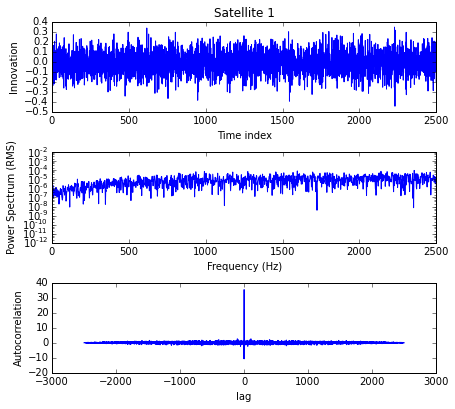

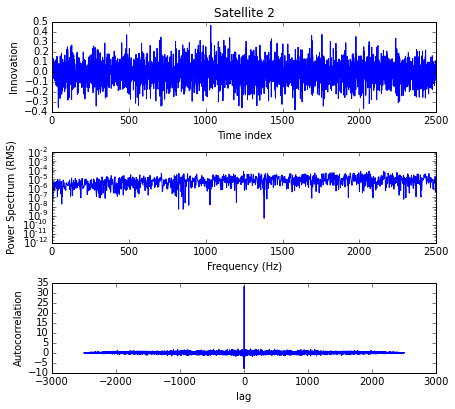

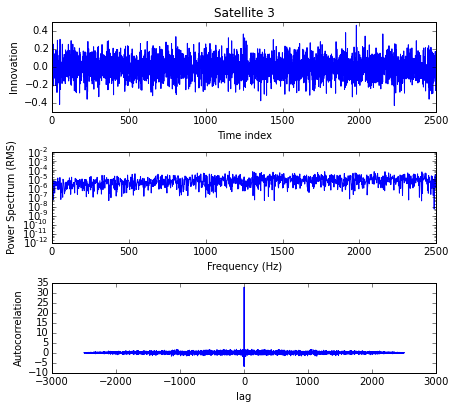

In [269]:

inv1 = inov_all[0,ts>=.5]
inv2 = inov_all[1,ts>=.5]
inv3 = inov_all[2,ts>=.5]

f, Pz1 = signal.periodogram(inv1, Fs, scaling = "spectrum")
f, Pz2 = signal.periodogram(inv2, Fs, scaling = "spectrum")
f, Pz3 = signal.periodogram(inv3, Fs, scaling = "spectrum")

Rr1 = correlate(inv1,inv1,mode = "full")
Rr2 = correlate(inv2,inv2,mode = "full")
Rr3 = correlate(inv3,inv3,mode = "full")

lag = range(-len(inv1)+1,len(inv1))

#plt.rc('text', usetex=False)

rcParams['text.usetex'] = False

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[0,ts<.5])
xlabel('Time index')
ylabel("Innovation")
title("Satellite 1")

subplot(312)
semilogy(f, Pz1)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr1)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q5_Innov_1_2nd_half.png', bbox_inches='tight')



fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[1,ts<.5])
xlabel('Time index')
#ylabel(r"$\tilde{y}$")
ylabel("Innovation")
title("Satellite 2")

subplot(312)
semilogy(f, Pz2)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr2)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q5_Innov_2_2nd_half.png', bbox_inches='tight')

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[2,ts<.5])
xlabel('Time index')
ylabel("Innovation")
title("Satellite 3")

subplot(312)
semilogy(f, Pz3)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr3)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q5_Innov_3_2nd_half.png', bbox_inches='tight')

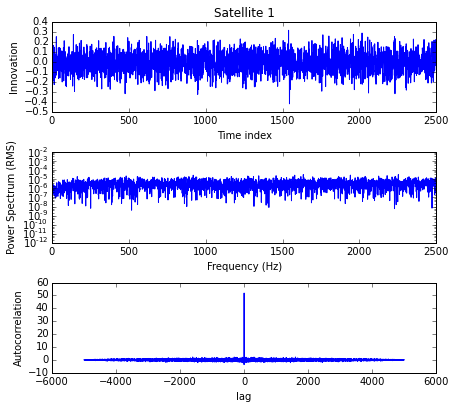

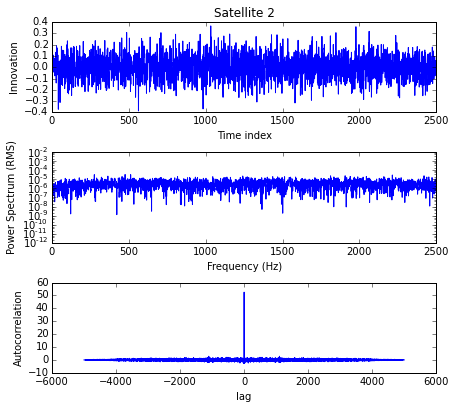

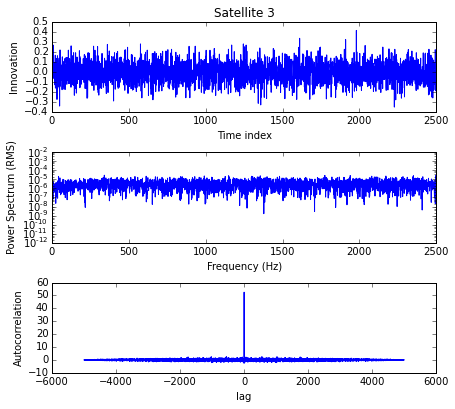

In [303]:
inv1 = inov_all[0,:]
inv2 = inov_all[1,:]
inv3 = inov_all[2,:]

f, Pz1 = signal.periodogram(inv1, Fs, scaling = "spectrum")
f, Pz2 = signal.periodogram(inv2, Fs, scaling = "spectrum")
f, Pz3 = signal.periodogram(inv3, Fs, scaling = "spectrum")

Rr1 = correlate(inv1,inv1,mode = "full")
Rr2 = correlate(inv2,inv2,mode = "full")
Rr3 = correlate(inv3,inv3,mode = "full")

lag = range(-len(inv1)+1,len(inv1))

#plt.rc('text', usetex=False)

#rcParams['text.usetex'] = False

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[0,ts<.5])
xlabel('Time index')
ylabel("Innovation")
title("Satellite 1")

subplot(312)
semilogy(f, Pz1)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr1)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q1_Innov_1_all.png', bbox_inches='tight')



fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[1,ts<.5])
xlabel('Time index')
#ylabel(r"$\tilde{y}$")
ylabel("Innovation")
title("Satellite 2")

subplot(312)
semilogy(f, Pz2)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr2)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q1_Innov_2_all.png', bbox_inches='tight')

fig, axes = plt.subplots(nrows=3, ncols=1)
fig.tight_layout()
subplots_adjust(top=1.3)

subplot(311)
plot(inov_all[2,ts<.5])
xlabel('Time index')
ylabel("Innovation")
title("Satellite 3")

subplot(312)
semilogy(f, Pz3)
xlabel('Frequency (Hz)')
ylabel("Power Spectrum (RMS)")
ylim(1e-12,1e-2)

subplot(313)
plot(lag, Rr3)
xlabel('lag')
ylabel("Autocorrelation")

savefig('R4Q1_Innov_3_all.png', bbox_inches='tight')

#Discussion

First, we choose a reference set of parameters as $Q=Q_1$ and $R=R_1$. We study different aspects of the filter's performance with these parameters. Then, we will change them and study their effect on the filer's behavior.

## Performance analysis

We have plotted the estimates versus the ground truth, the standard deviation of estimion errors, and the norm of Kalman gain. The figures show that the filter can track poistion quickly even after $t>0.5$. It is not as agile in tracking velocity. The reason is we are using a constant velocity model. As a result, the filter does not expect the volicities to change. One way to resolve this issue is to increase the uncertainties assocated with velocity model. As the figures show, the filter has not reached to its steady state condition. 


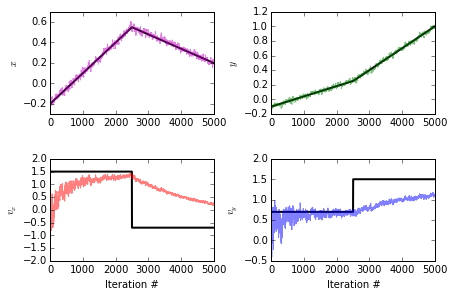

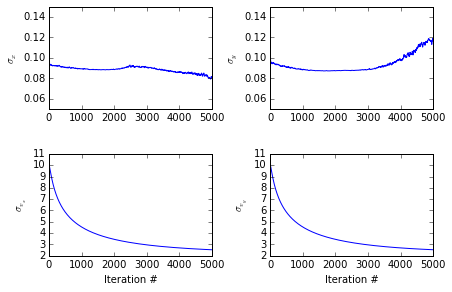

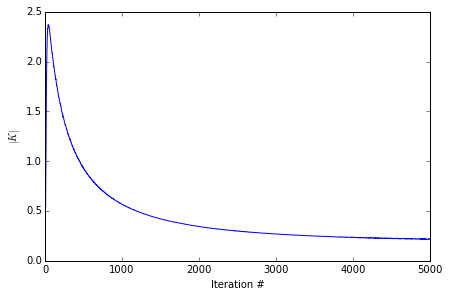

In [256]:
display(Image("R1Q1/R1Q1_Xhat.png"))
display(Image("R1Q1/R1Q1_sigma.png"))
display(Image("R1Q1/R1Q1_K.png"))

We can aslo study the innovation to gain some more knowlge about the filter's performance. As the following filter's show, the innovation signals are relatively uncorrelated, and their spectrums are relatively flat.

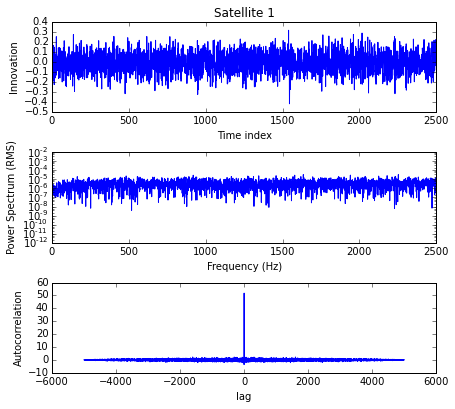

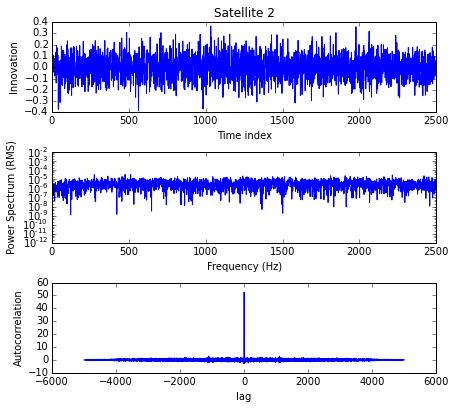

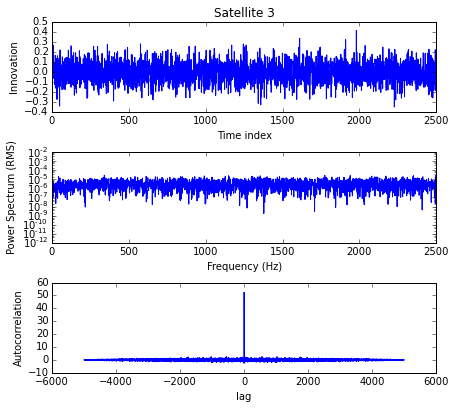

In [258]:
display(Image("R1Q1/R1Q1_Innov_1_all.png"))
display(Image("R1Q1/R1Q1_Innov_2_all.png"))
display(Image("R1Q1/R1Q1_Innov_3_all.png"))



# Effect of process model uncertainy 

First, we increase the velocity uncertainties ($q_{v_x}$ and $q_{v_y}$) by chossing $Q=Q_2$, and $Q=Q_3$. As the figures show, by incraseing velocity uncertainties, the filter becomes more agile, and can react to large changes in velocity more quickly. The negative side is that the estimation error standard deviation increases, and the filter becomes less stable. Kalman gain plots confirm this too.

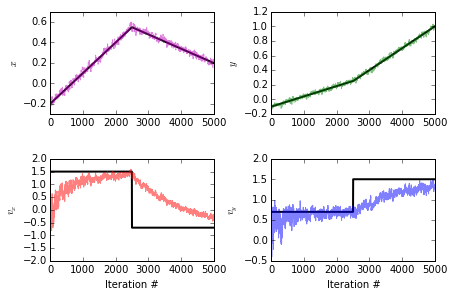

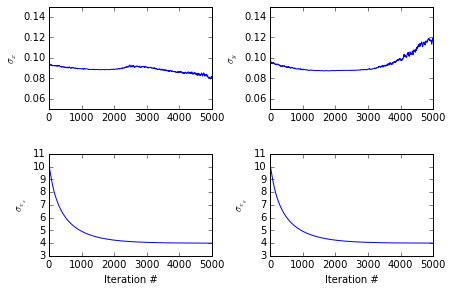

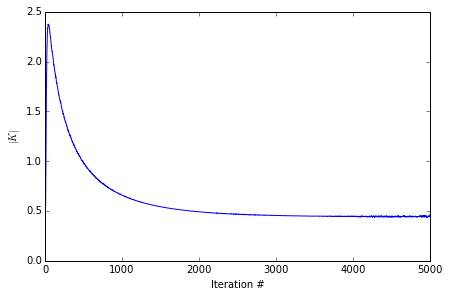

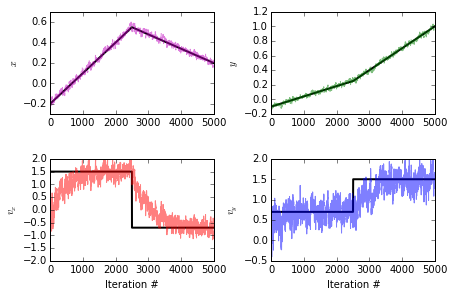

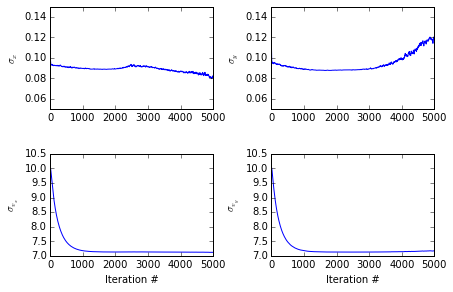

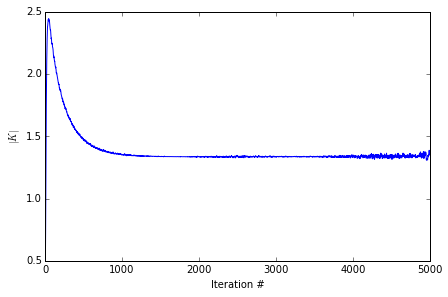

In [274]:

display(Image("R1Q2/R1Q2_Xhat.png"))
display(Image("R1Q2/R1Q2_sigma.png"))
display(Image("R1Q2/R1Q2_K.png"))

display(Image("R1Q3/R1Q3_Xhat.png"))
display(Image("R1Q3/R1Q3_sigma.png"))
display(Image("R1Q3/R1Q3_K.png"))


Now, we increase position uncertainties ($q_{x}$ and $q_{y}$) by chossing $Q=Q_4$, and $Q=Q_5$. As the plots show, by increasing position uncertainties, the estimation error covariance goes up and the filter becomes less stable. Another intersting observation is the coupling relation between position and velocity estimates. As a result, the velocity estimates have deterioated severly as well. The effect is more dramatic especially because the filter does not have access to any velocity measurements.


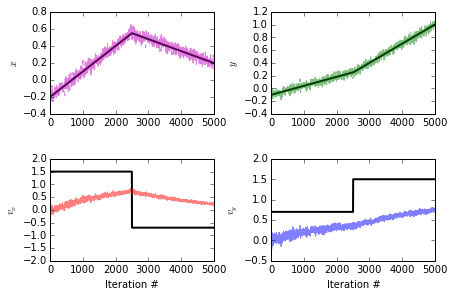

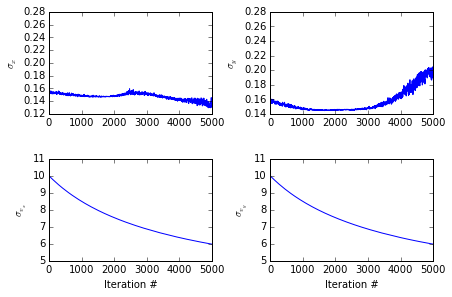

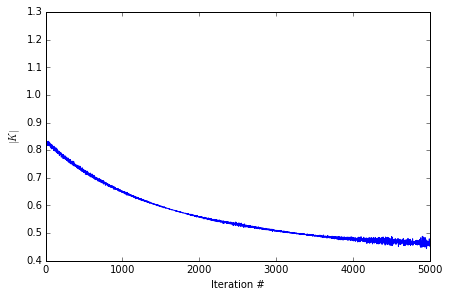

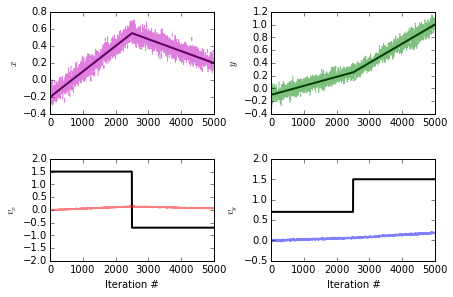

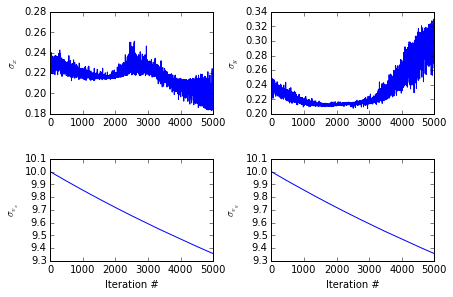

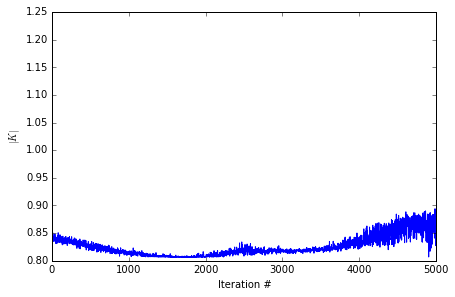

In [275]:
display(Image("R1Q4/R1Q4_Xhat.png"))
display(Image("R1Q4/R1Q4_sigma.png"))
display(Image("R1Q4/R1Q4_K.png"))

display(Image("R1Q5/R1Q5_Xhat.png"))
display(Image("R1Q5/R1Q5_sigma.png"))
display(Image("R1Q5/R1Q5_K.png"))

Let's monitor the innovation. As the following plots confirm, the spectrum is becoming less flat, and the autocorrelation function shows that the innovation signals have become more correlated.

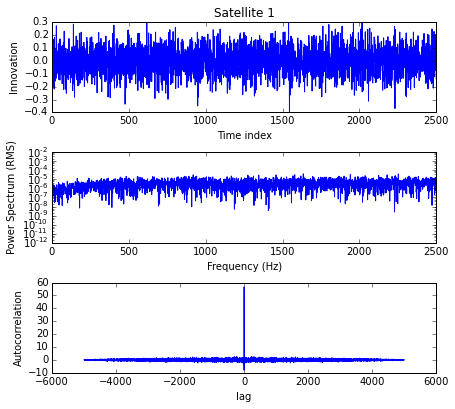

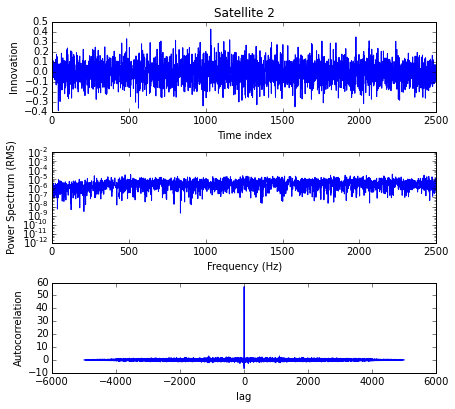

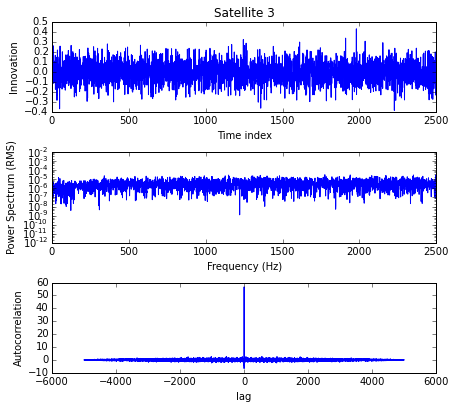

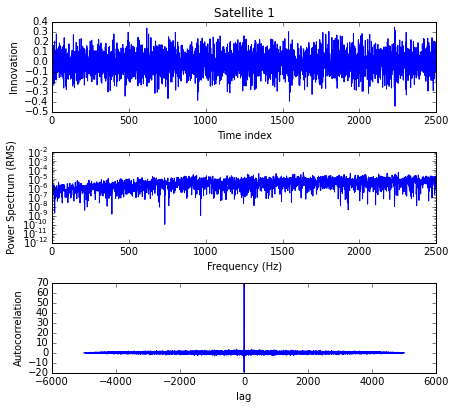

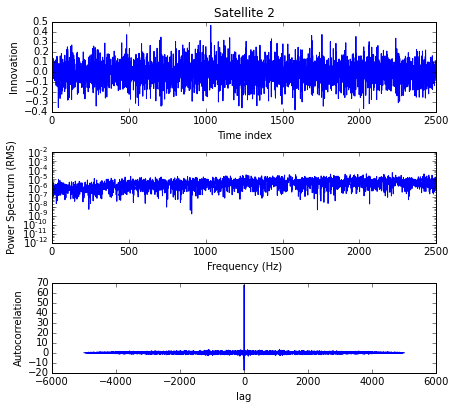

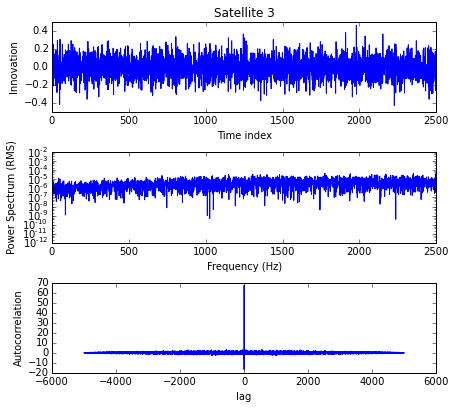

In [278]:
display(Image("R1Q4/R1Q4_Innov_1_all.png"))
display(Image("R1Q4/R1Q4_Innov_2_all.png"))
display(Image("R1Q4/R1Q4_Innov_3_all.png"))

display(Image("R1Q5/R1Q5_Innov_1_all.png"))
display(Image("R1Q5/R1Q5_Innov_2_all.png"))
display(Image("R1Q5/R1Q5_Innov_3_all.png"))


##Efefct of measurement uncertainty

As the plots show, by increasing $R$, the Kalman gain becomes smaller, and the estimation erros's standard deviation increases. As a result, the process model's role becomes more significant. Hence, the state estimates become more smooth.

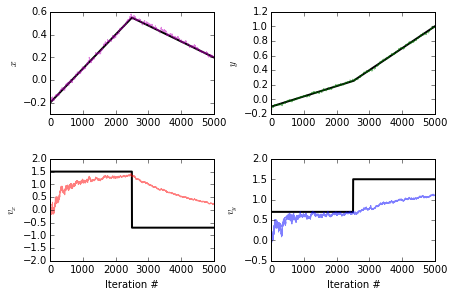

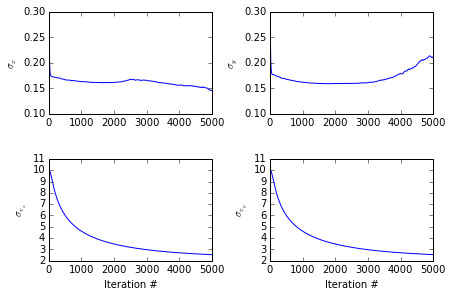

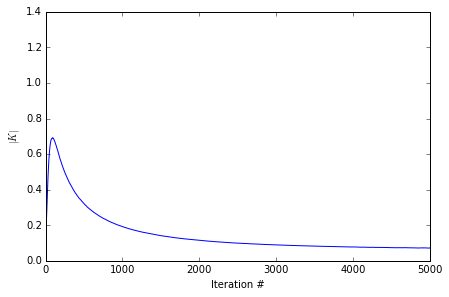

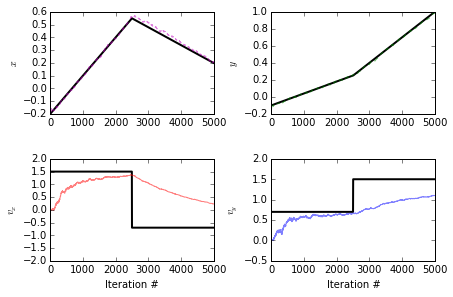

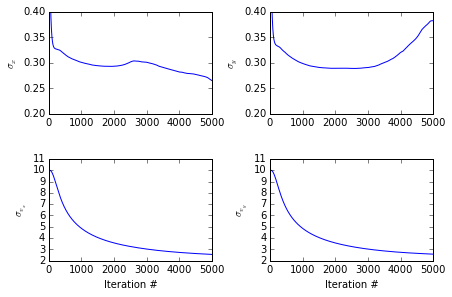

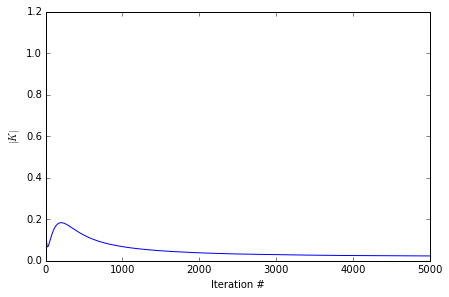

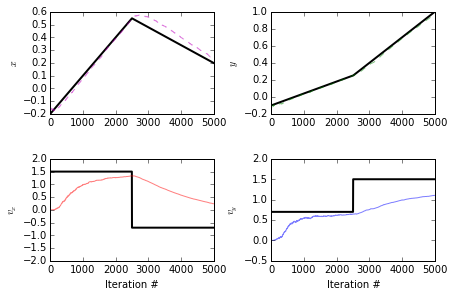

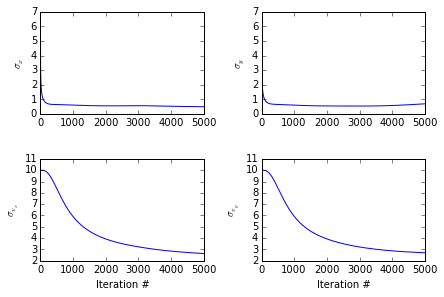

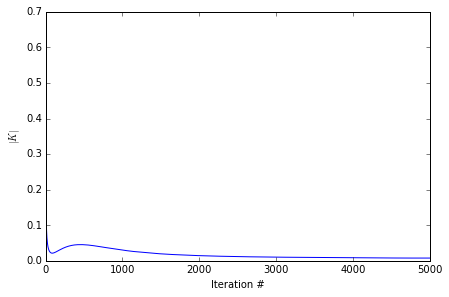

In [291]:

display(Image("R2Q1/R2Q1_Xhat.png"))
display(Image("R2Q1/R2Q1_sigma.png"))
display(Image("R2Q1/R2Q1_k.png"))


display(Image("R3Q1/R3Q1_Xhat.png"))
display(Image("R3Q1/R3Q1_sigma.png"))
display(Image("R3Q1/R3Q1_k.png"))


display(Image("R4Q1/R4Q1_Xhat.png"))
display(Image("R4Q1/R4Q1_sigma.png"))
display(Image("R4Q1/R4Q1_k.png"))



## An attempt to improve velocity tracking
To be able to track changes in velocity, we need to let the filter know that our constant velocity model is not so accurate.
Therfore, we pick $Q=Q_3$ which has higher velocity model uncertainties. 

At the same time, we want the filter to put less weight on the measurements, so that the estimate results become more smooth.

The obtined results are plotted below. We can see some lag on $x$-direction position estimate, which can be explained by the fact that the filter trusts the measurements less than before. Since the filter is putting less weight on the measurements, for it to estimate the position, the velocity estimate needs to converge. Hence, we see the lag in tracking velocities after $t>0.5$.


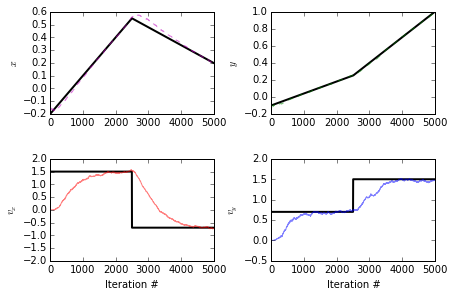

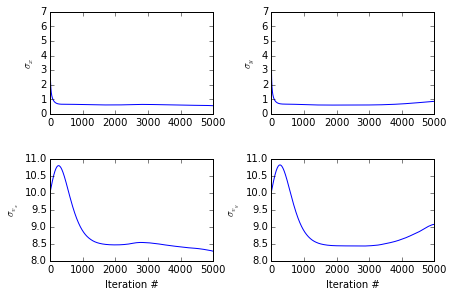

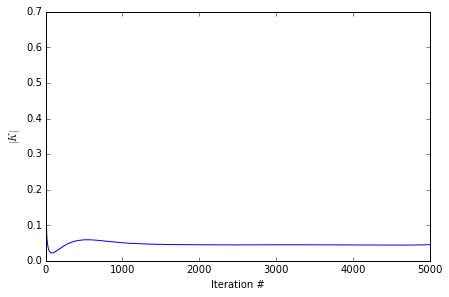

In [295]:

display(Image("R4Q3/R4Q3_Xhat.png"))
display(Image("R4Q3/R4Q3_sigma.png"))
display(Image("R4Q3/R4Q3_K.png"))


